## Image preprocessing


The algorithm should be able to process an image like this:

![image_example](image_example.png)

into the MNIST-like image.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torchvision.transforms as T

In [50]:
im = T.Grayscale()(Image.open("image_example.png"))
npim = np.array(im)
ptim = torch.from_numpy(npim)
ptim[:4, :5]

tensor([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]], dtype=torch.uint8)

In [51]:
npim.shape

(283, 587)

In [52]:
npim[271:281, 465:475]

array([[242, 242, 242, 242, 242, 242, 242, 242, 242, 242],
       [242, 242, 242, 242, 242, 242, 242, 242, 242, 242],
       [242, 242, 242, 242, 242, 242, 242, 242, 242, 242],
       [242, 242, 242, 242, 242, 242, 242, 242, 242, 242],
       [242, 242, 242, 242, 242, 242, 216, 180, 140,  34],
       [242, 219, 183, 144,  96,  40,  13,  11,   8,   1],
       [ 46,  14,  11,   9,   5,   2,   0,   0,   0,   0],
       [  2,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0]], dtype=uint8)

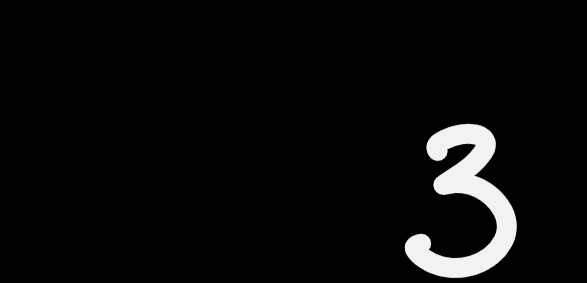

In [53]:
im

In [54]:
np.amin(np.where(npim > 0), axis=1)

array([123, 404], dtype=int64)

In [55]:
torch.amin(torch.stack(torch.where(ptim > 0)), dim=1)

tensor([123, 404])

([], [])

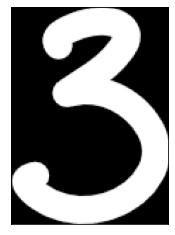

In [56]:
top, left = torch.amin(torch.stack(torch.where(ptim > 0)), dim=1)
bottom, right = torch.amax(torch.stack(torch.where(ptim > 0)), dim=1)
plt.imshow(ptim[top:bottom, left:right], cmap='gray')
plt.xticks([])
plt.yticks([])

In [57]:
center = torch.tensor([(top.item() + bottom.item()) // 2, (left.item() + right.item()) // 2])
center

tensor([200, 460])

In [58]:
imrad = max(bottom - center[0], right - center[1])
imrad

tensor(78)

In [59]:
center + imrad < torch.tensor(ptim.size())

tensor([True, True])

In [60]:
torch.tensor(ptim.size()) - (center + imrad)

tensor([ 5, 49])

([], [])

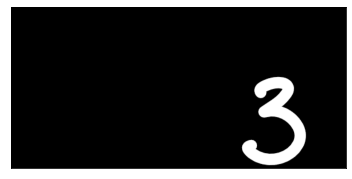

In [61]:
if sum(center + imrad < torch.tensor(ptim.size())) < 2 or sum(center - imrad > 0) < 2:
    br_offsite = abs(min(torch.tensor(ptim.size()) - (center + imrad)))
    tl_offsite = abs(min(center - imrad))
    pad = max(br_offsite, tl_offsite)
    ptim_2 = T.Pad(padding=pad.item())(ptim)
    center += pad
else:
    ptim_2 = ptim
    
plt.imshow(ptim_2, cmap='gray')
plt.xticks([])
plt.yticks([])

In [62]:
ptim.size(), ptim_2.size()

(torch.Size([283, 587]), torch.Size([283, 587]))

In [63]:
topc, leftc = center - imrad
bottomc, rightc = center + imrad
topc, leftc

(tensor(122), tensor(382))

([], [])

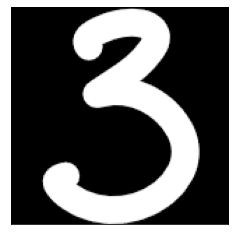

In [64]:
ptim_3 = ptim_2[topc:bottomc, leftc:rightc]
plt.imshow(ptim_3, cmap='gray')
plt.xticks([])
plt.yticks([])

([], [])

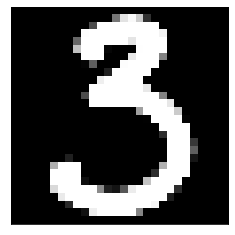

In [67]:
ptim_4 = T.Resize(size=[26, 26])(ptim_3.view(1, 1, *ptim_3.size())).view(26, 26)
ptim_4 = T.Pad(padding=1)(ptim_4)
plt.imshow(ptim_4, cmap='gray')
plt.xticks([])
plt.yticks([])

In [68]:
ptim_4.size()

torch.Size([28, 28])

In [69]:
def prepare_image(im, back_val=0, output_size=28):
    """Prepares an image for training
    
    Parameters
    ----------
        im : PIL image
            An input image.
        back_val : integer, optional
            The 8 bit color value which considered to be 
            a background of the image. Default 0.
            (0 <= back_val <= 255) 
        output_size : integer, optional
            The size of the output image. Default 28.
    """
    # Convert to grayscale PyTorch Tensor
    ptim = torch.from_numpy(np.array(T.Grayscale()(im)))
    
    # Find the digit in the image
    top, left = torch.amin(torch.stack(
        torch.where(ptim > back_val)), dim=1)
    bottom, right = torch.amax(torch.stack(
        torch.where(ptim > back_val)), dim=1)
    center = torch.tensor([
        (top.item() + bottom.item()) // 2, 
        (left.item() + right.item()) // 2,
    ])
    imrad = max(bottom - center[0], right - center[1])
    
    # Make a padding if the (center + radius) is biger 
    # then an input image or (center - radius) < 0.
    if (sum(center + imrad < torch.tensor(ptim.size())) < 2 
        or sum(center - imrad > 0) < 2):
        
        br_offsite = abs(min(torch.tensor(ptim.size()) - (center + imrad)))
        tl_offsite = abs(min(center - imrad))
        pad = max(br_offsite, tl_offsite)
        ptim = T.Pad(padding=pad.item())(ptim)
        center += pad
    
    # Crop and resize the image
    topc, leftc = center - imrad
    bottomc, rightc = center + imrad
    ptim = ptim[topc:bottomc, leftc:rightc]
    ptim = ptim.view(1, 1, *ptim.size())
    ptim = T.Resize(size=[output_size-2, output_size-2])(ptim)
    ptim = ptim.view(output_size-2, output_size-2)
    ptim = T.Pad(padding=1)(ptim)
    
    return ptim
    

([], [])

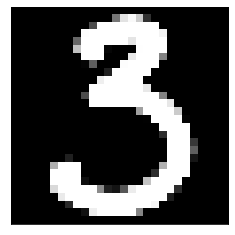

In [71]:
plt.imshow(prepare_image(im), cmap='gray')
plt.xticks([])
plt.yticks([])